https://www.kaggle.com/datasets/camnugent/california-housing-prices
 

![alt text](IMG/pt1.jpg)



![alt text](IMG/pt2.jpg) 

## Set up

In [80]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor

df = pd.read_csv('data/housing.csv')

## Data Exploration

In [81]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [82]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [32]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


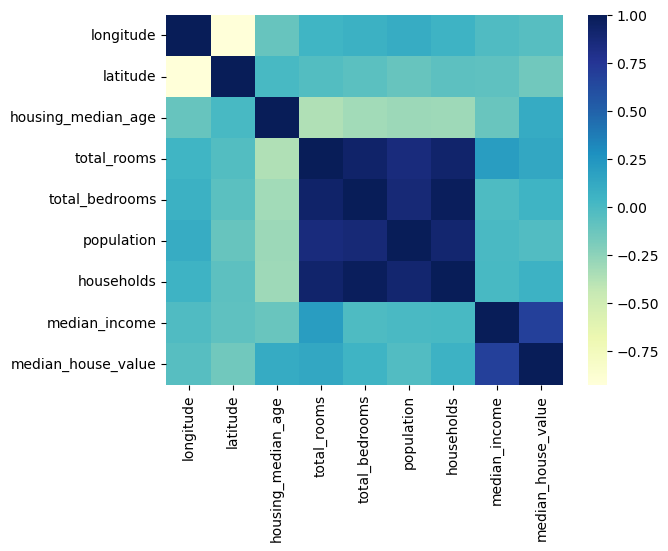

In [83]:

import seaborn as sns
sns.heatmap(df.corr(numeric_only=True), cmap='YlGnBu')
plt.show()


## [Data Analysis 1] Location and housing value

In [153]:
df.groupby('ocean_proximity').agg(Income=('median_income', 'mean'),
                                    House_value=('median_house_value', 'mean'),
                                    Count=('median_house_value', 'count'))


,Income,House_value,Count
ocean_proximity,,,
<1H OCEAN,4.230682,240084.285464,9136
INLAND,3.208996,124805.392001,6551
ISLAND,2.744420,380440.000000,5
NEAR BAY,4.172885,259212.311790,2290
NEAR OCEAN,4.005785,249433.977427,2658


In [146]:
# Define the mapping dictionary
mapping_dict = {
    'NEAR BAY': 'Coastal',
    'NEAR OCEAN': 'Coastal',
    '<1H OCEAN': 'Coastal',
    'INLAND': 'Inland',
    'ISLAND': 'Island'}

df1 = df[['ocean_proximity','median_income','median_house_value']]
df1['Location'] = df1['ocean_proximity'].map(mapping_dict)
df1 = df1[df1['Location'] != 'Island']

df2 = df1.groupby('Location')[['median_income','median_house_value']].mean()
df2

/var/folders/82/038lb7sx7w981ctcvb0s2px00000gn/T/ipykernel_68826/2957002329.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Location'] = df1['ocean_proximity'].map(mapping_dict)


,median_income,median_house_value
Location,,
Coastal,4.178841,244958.941920
Inland,3.208996,124805.392001


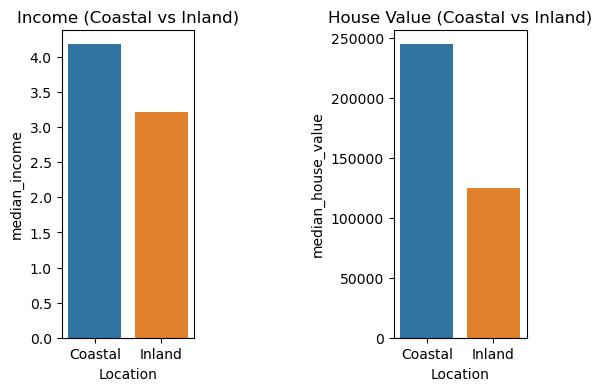

In [161]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with two subplots (1 row, 2 columns)
plt.figure(figsize=(6, 4))

# First plot (median_income)
plt.subplot(1, 2, 1)  # (rows, columns, position)
sns.barplot(data=df2, x='Location', y='median_income', hue='Location')
plt.title('Income (Coastal vs Inland)')

# Second plot (median_house_value)
plt.subplot(1, 2, 2)
sns.barplot(data=df2, x='Location', y='median_house_value', hue='Location')
plt.title('House Value (Coastal vs Inland)')


plt.subplots_adjust(wspace=1.5)

# Show the plots
plt.show()


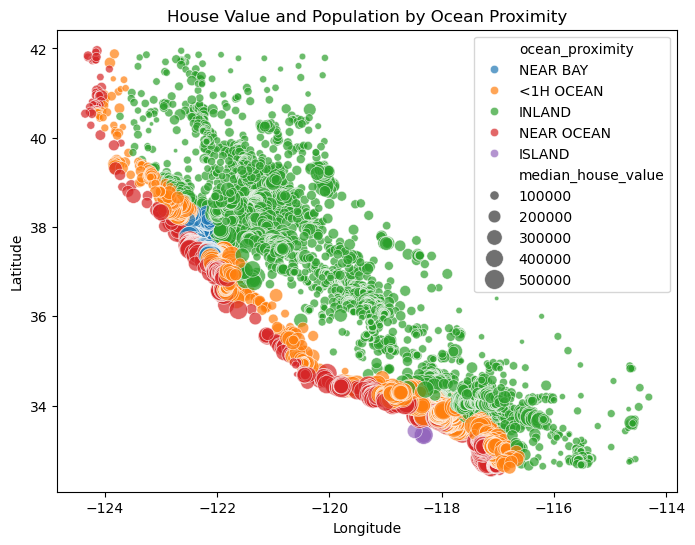

In [152]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df, x="longitude", y="latitude", size="median_house_value", 
    sizes=(10, 200), 
    hue="ocean_proximity", 
    alpha=0.7
)
plt.title("House Value and Population by Ocean Proximity")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
#plt.legend(title="Ocean Proximity", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

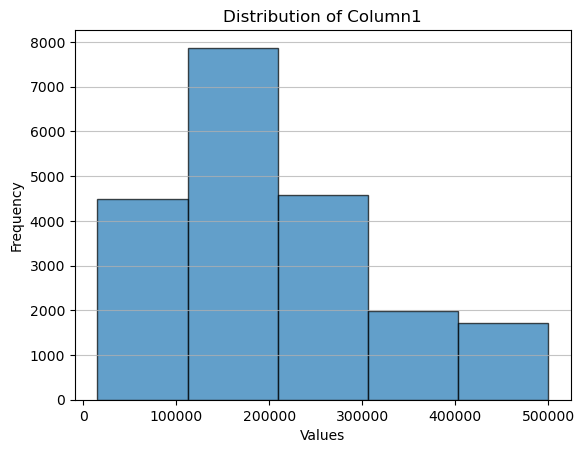

In [28]:
plt.hist(df['median_house_value'], bins=5, edgecolor='black', alpha=0.7)
plt.title('Distribution of Column1')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

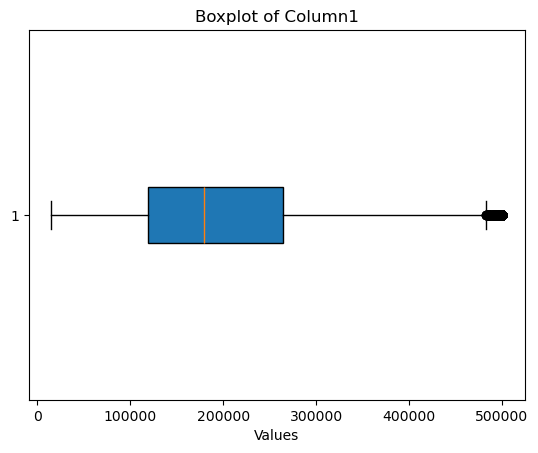

In [29]:
plt.boxplot(df['median_house_value'], vert=False, patch_artist=True)
plt.title('Boxplot of Column1')
plt.xlabel('Values')
plt.show()

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", 
             alpha=0.1, s=housing["population"]/100, label="population",
            c="median_house_value", cmap=plt.get_cmap("jet"))